## Изучение данных

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

In [6]:
df[['calls', 'messages']] = df[['calls', 'messages']].astype('int').copy()

In [7]:
df.duplicated().sum()

0

Полных дубликатов и пропущенных значений нет. Еще перевел тип данных у двух признаков из float в integer.

In [8]:
df.drop('is_ultra', axis=1).corr().style.background_gradient(cmap='Reds')

,calls,minutes,messages,mb_used
calls,1,0.982083,0.177385,0.286442
minutes,0.982083,1,0.17311,0.280967
messages,0.177385,0.17311,1,0.195721
mb_used,0.286442,0.280967,0.195721,1


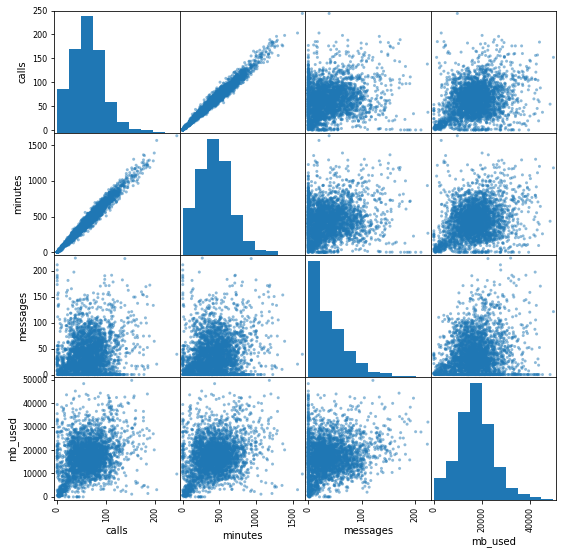

In [9]:
pd.plotting.scatter_matrix(df.drop('is_ultra', axis=1), figsize=(9, 9));

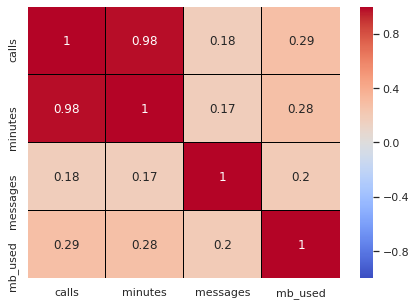

In [10]:
sns.set(rc={'figure.figsize':(7, 5)})
sns.heatmap(df.drop('is_ultra', axis=1).corr(),
            annot=True,
            vmin=-1,
            vmax=1,
            center= 0,
            cmap='coolwarm',
            linewidths=.01,
            linecolor='black');

В принципе хитмап мог уже не делать. И так понятно, что 'calls' и 'minutes' очень сильно коррелируют между собой. В таком случае мы уберем из обучения 'minutes'.

In [11]:
df = df.drop('calls', axis=1).copy()

In [12]:
df.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83,19915.42,0
1,516.75,56,22696.96,0
2,467.66,86,21060.45,0
3,745.53,81,8437.39,1
4,418.74,1,14502.75,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(2)
memory usage: 100.6 KB


In [14]:
df.describe()

,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,438.208787,38.281269,17207.673836,0.306472
std,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000
25%,274.575000,9.000000,12491.902500,0.000000
50%,430.600000,30.000000,16943.235000,0.000000
75%,571.927500,57.000000,21424.700000,1.000000
max,1632.060000,224.000000,49745.730000,1.000000


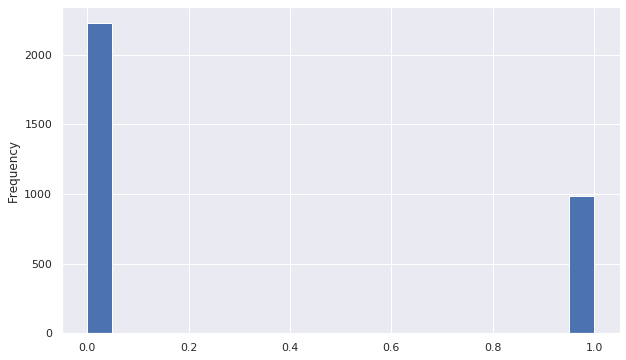

In [15]:
df['is_ultra'].plot(kind='hist',
                    bins=20,
                    figsize=(10, 6),
                    grid=True);

Итого у нас получился датасет из 4 признаков. Целевой признак распределен неравномерно. Клиентов на тарифе Ультра почти в 2 раза меньше, чем клиентов на тарифе Смарт. Мы это учтем чуть позже.

## Разбиение данных на выборки

Целевой признак - 'is_ultra'

In [16]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

Сначала разобью на train (80%) и test (20%), а потом поставлю кроссвалидацию, равную 4 (т.е. validate = 20%).

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['is_ultra'])

In [18]:
len(df)

3214

In [19]:
len(X_train)

2571

In [20]:
len(X_test)

643

In [21]:
len(X_train) + len(X_test)

3214

In [22]:
len(X_train) + len(X_test) == len(y_train) + len(y_test)

True

In [23]:
df['is_ultra'].mean()

0.30647168637212197

In [24]:
y_train.mean()

0.30649552703228317

In [25]:
y_test.mean()

0.30637636080870917

## Исследование моделей

In [26]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Классы не сбалансированны.

In [27]:
clf_dt = DecisionTreeClassifier(random_state=42)

In [28]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'class_weight': [{0: n, 1: 1.0 - n} for n in weights]}

Задал пока что только вариации весов. Благодаря гиперпараметру cv=StratifiedKFold(4) у меня получается валидационная выборка, равная 20% от всего датасета. В качестве метрики выбрал f1-меру, чтобы был баланс между точностью и полнотой.

In [29]:
grid_search_cv = GridSearchCV(clf_dt,
                              parameters,
                              scoring='f1',
                              n_jobs=-1,
                              cv=StratifiedKFold(4)).fit(X_train, y_train)

In [30]:
grid_search_cv.best_params_

{'class_weight': {0: 0.9502010050251256, 1: 0.04979899497487439}}

In [31]:
parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 21),
              'min_samples_split': range(2, 21, 5),
              'min_samples_leaf': range(1, 21, 5),
              'class_weight': [{0: 0.9502010050251256, 1: 0.04979899497487439}]}

Задал новые параметры для GridSearchCV. И здесь я уже беру метрику accuracy

In [32]:
grid_search_cv_dt = GridSearchCV(clf_dt,
                                 parameters,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [33]:
grid_search_cv_dt.best_params_

{'class_weight': {0: 0.9502010050251256, 1: 0.04979899497487439},
 'criterion': 'gini',
 'max_depth': 14,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [34]:
best_clf_dt = grid_search_cv_dt.best_estimator_

In [35]:
predictions_dt = best_clf_dt.predict(X_train)

In [36]:
accuracy_score(y_train, predictions_dt)

0.8424737456242707

На тренировочной выборке решающее дерево показало accuracy = 0.8424737456242707

Теперь все то же самое проделаем для случайного леса и логистической регрессии.

In [37]:
clf_rf = RandomForestClassifier(random_state=42)

In [38]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'n_estimators': [50],
              'class_weight': [{0: n, 1: 1.0 - n} for n in weights]}

In [39]:
grid_search_rf = GridSearchCV(clf_rf,
                              parameters,
                              scoring='f1',
                              n_jobs=-1,
                              cv=StratifiedKFold(4)).fit(X_train, y_train)

In [40]:
grid_search_rf.best_params_

{'class_weight': {0: 0.9352763819095478, 1: 0.06472361809045224},
 'n_estimators': 50}

In [41]:
parameters = {'n_estimators': range(50, 201, 50),
              'criterion': ['gini', 'entropy'],
              'max_depth': range(1, 21),
              'min_samples_split': range(2, 22, 10),
              'min_samples_leaf': range(1, 21, 10),
              'class_weight': [{0: 0.9352763819095478, 1: 0.06472361809045224}]}

In [42]:
grid_search_cv_rf = GridSearchCV(clf_rf,
                                 parameters,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [43]:
grid_search_cv_rf.best_params_

{'class_weight': {0: 0.9352763819095478, 1: 0.06472361809045224},
 'criterion': 'gini',
 'max_depth': 18,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [44]:
best_clf_rf = grid_search_cv_rf.best_estimator_

In [45]:
predictions_rf = best_clf_rf.predict(X_train)

In [46]:
accuracy_score(y_train, predictions_rf)

0.8914819136522754

На тренировочной выборке случайный лес показал accuracy = 0.8914819136522754

In [47]:
clf_lr = LogisticRegression()

In [48]:
weights = np.linspace(0.0, 0.99, 200)
parameters = {'class_weight': [{0: n, 1: 1.0 - n} for n in weights],
              'solver': ['lbfgs']}

In [49]:
grid_search_lr = GridSearchCV(clf_lr,
                              parameters,
                              scoring='f1',
                              n_jobs=-1,
                              cv=StratifiedKFold(4)).fit(X_train, y_train)

In [50]:
grid_search_lr.best_params_

{'class_weight': {0: 0.2935175879396985, 1: 0.7064824120603015},
 'solver': 'lbfgs'}

In [51]:
parameters = {'class_weight': [{0: 0.2935175879396985, 1: 0.7064824120603015}],
              'solver': ['lbfgs']}

In [52]:
grid_search_cv_lr = GridSearchCV(clf_lr,
                                 parameters,
                                 scoring='accuracy',
                                 n_jobs=-1,
                                 cv=StratifiedKFold(4)).fit(X_train, y_train)

In [53]:
grid_search_cv_lr.best_params_

{'class_weight': {0: 0.2935175879396985, 1: 0.7064824120603015},
 'solver': 'lbfgs'}

In [54]:
best_clf_lr = grid_search_cv_lr.best_estimator_

In [55]:
predictions_lr = best_clf_lr.predict(X_train)

In [56]:
accuracy_score(y_train, predictions_lr)

0.337611824192921

На тренировочной выборке логистическая регрессия показала наихудший результат: accuracy = 0.337611824192921

## Проверка на тестовой выборке

In [57]:
predictions_dt_test = best_clf_dt.predict(X_test)

In [58]:
accuracy_score(y_test, predictions_dt_test)

0.8133748055987559

In [59]:
predictions_rf_test = best_clf_rf.predict(X_test)

In [60]:
accuracy_score(y_test, predictions_rf_test)

0.8164852255054432

In [61]:
predictions_lr_test = best_clf_lr.predict(X_test)

In [62]:
accuracy_score(y_test, predictions_lr_test)

0.359253499222395

Лучший результат дал random forest: accuracy = 0.8164852255054432. Правда и обучался намного дольше остальных. Если время обучения не критично, то его мы и будем использовать для внедрения. Худший результат дала логистическая регрессия. Она не дотянула даже до значения 0.75.

## Проверка моделей на адекватность

In [63]:
1 - y.mean()

0.693528313627878

In [64]:
clf_dummy = DummyClassifier(strategy='most_frequent', random_state=42)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.6936236391912908

In [65]:
clf_dummy = DummyClassifier(strategy='stratified', random_state=42)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.5909797822706065

In [66]:
clf_dummy = DummyClassifier(strategy='prior', random_state=42)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.6936236391912908

In [67]:
clf_dummy = DummyClassifier(strategy='uniform', random_state=42)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.49144634525660963

Получается, что лучший DummyClassifier выдал точность прогноза 0.6936236391912908. Это почти соответствует доле клиентов на тарифе Смарт. Наши обученные дерево решений и случайный лес явно лучше модели, которая предсказывает нулевой класс для всех. А вот логистическая регрессия совершенно невменяема)